<a href="https://colab.research.google.com/github/andrew-alberts/deep-learning-cv-tutorial/blob/main/dl_and_cv_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning and Computer Vision Tutorial

This notebook walks through an introductory computer vision task which uses deep learning to determine the make of car from it's picture. The dataset used is Stanford196 and the Tensorflow and Keras frameworks are used throughout.

### Agenda

1. General notebook setup
2. Loading the data
3. Data preprocessing
4. Fully-connected neural network
5. Convolutional neural network (CNN)
6. ResNet



### 1 - General notebook setup

Colab fortunately is already well equipped for us, but we need to use a GPU. To do so click Runtime > Change runtime type and select GPU as the Hardware accelerator (GPU).

Now, we can verify we have a GPU and see what version of TensorFlow is available.

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.4.1


We need to mount a Google drive if the dataset is already downloaded and residing in the drive (set LOAD_FROM_DRIVE to True). If not, keep it as false and the dataset will be downloaded on the fly.

In [7]:
LOAD_FROM_DRIVE = True

data_dir = None
download = True

if LOAD_FROM_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  data_dir = 'drive/MyDrive/tensorflow_datasets'
  download = False

Mounted at /content/drive


### 2 - Load the dataset

Loading the Cars196 dataset is really easy using the tensorflow_datasets module. The tfds.load function takes care of either downloading the data or simply loading the data from a mounted drive.

In [135]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load('Cars196', split=['train', 'test'], data_dir=data_dir, download=download,
                                         with_info=True, shuffle_files=True, as_supervised=True)
print("ds_train type", type(ds_train))
print("ds_info type", type(ds_info))

ds_train type <class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>
ds_info type <class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


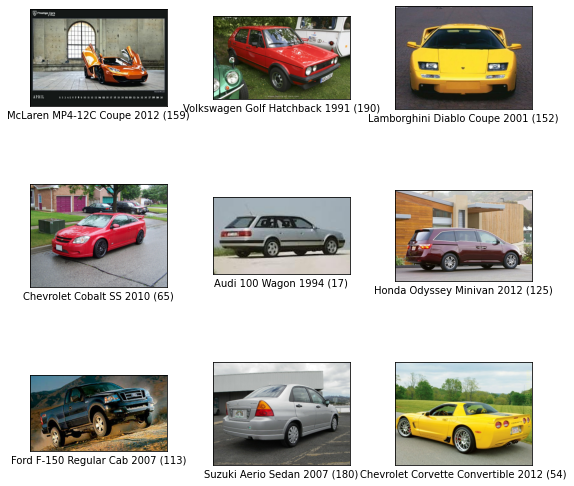

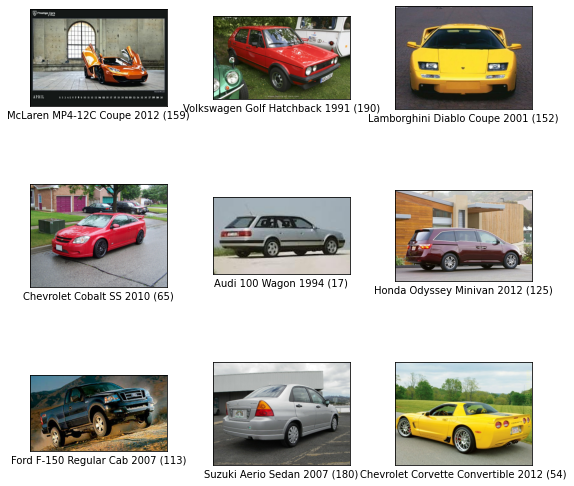

In [25]:
tfds.visualization.show_examples(ds_train, ds_info)

Check out a sample of the image labels. There are 196 distinct classes in the form *make model year*.

In [30]:
print("# classes", len(ds_info._features['label']._str2int), "\n")
{s:i for s, i in ds_info._features['label']._str2int.items() if (i % 18) == 0}

# classes 196 



{'AM General Hummer SUV 2000': 0,
 'Audi TT Hatchback 2011': 18,
 'BMW X3 SUV 2012': 36,
 'Chevrolet Corvette Convertible 2012': 54,
 'Chevrolet Malibu Sedan 2007': 72,
 'Dodge Dakota Club Cab 2007': 90,
 'Ford Expedition EL SUV 2009': 108,
 'Honda Odyssey Minivan 2007': 126,
 'Jeep Patriot SUV 2012': 144,
 'Mercedes-Benz SL-Class Coupe 2009': 162,
 'Suzuki Aerio Sedan 2007': 180}

How is the data actually represented? Their data types are tf.Tensor where the image has dimension *H*x*W*x*3* and the label is a scalar. By looking at two different samples we see the images have different heights and widths.

In [59]:
def show_tensors(ds):
  for img, lbl in ds.take(2):
    print("Image")
    print(type(img), img.shape)
    print("Label", lbl)
    print(type(lbl), lbl.shape)
    print(50*"-")

show_tensors(ds_train)

Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (398, 531, 3)
Label tf.Tensor(153, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------
Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (668, 1200, 3)
Label tf.Tensor(101, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------


Visualize one image sample.

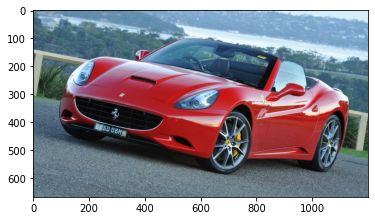

In [51]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(img.numpy(), cmap='gray')

### 3 - Data preprocessing

Since the labels have more information than just the make, let's strip out the model and year for this tutorial. The functions below will be used to map the 196 classes down to 48 classes.

In [55]:
def label_str_to_make(label_str):
  lbl = label_str.upper()
  if "HUMMER" in lbl:
    return "AM"
  elif "ASTON MARTIN" in lbl:
    return "ASTON MARTIN"
  elif "LAND ROVER" in lbl:
    return "LAND ROVER"
  else:
    return lbl.split(" ")[0]

makes = list(set([label_str_to_make(x) for x in ds_info._features['label']._int2str]))

def get_new_label(label_int):
  label_str = ds_info._features['label']._int2str[label_int]
  make = label_str_to_make(label_str)
  return makes.index(make)

print("# classes", len(makes), ",  examples", makes[0:5])

# classes 48 ,  examples ['SMART', 'MERCEDES-BENZ', 'TESLA', 'GEO', 'LAND ROVER']


Our neural nets will require the input images to have a fixed size but we saw that is not the case. Let's write a function to reshape images to be *150*x*150*x*3*. It is also common practice to normalize pixel values to be between 0 to 1 (instead of 0 to 255).


In [57]:
def normalize_img(img, size=150):
  img = tf.image.resize(img, (size,size), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)
  img = img / 255.
  return img

What does a resized picture look like?

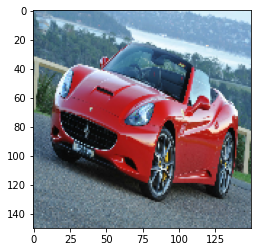

In [58]:
plt.imshow(normalize_img(img).numpy(), cmap='gray')

With the functions to relabel the samples and reshape them, we can now apply these preprocessing steps to the training data.

In [136]:
def relabel_and_reshape(img, label):
  lbl = tf.numpy_function(
      func=get_new_label, inp=[label], Tout=tf.int64
  )
  return normalize_img(img), lbl

ds_train = ds_train.map(relabel_and_reshape, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Check the reshaping worked.

In [62]:
show_tensors(ds_train)

Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (150, 150, 3)
Label tf.Tensor(5, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------
Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (150, 150, 3)
Label tf.Tensor(45, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------


Another common practice is to zero-centre the images so that all pixels have an average of 0. To do this we need to first calculate the mean of the pixel values:

In [137]:
total_tensor = tf.zeros([150, 150, 3])
n = 0

for img, _ in iter(ds_train):
  n += 1
  total_tensor += img

avg_tensor = total_tensor / n
print("Shape", avg_tensor.shape)

Shape (150, 150, 3)


Now we need to subtract the mean from all images in our training dataset.

In [138]:
def centre_images(img, label):
  return (img-avg_tensor), label

ds_train = ds_train.map(centre_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Finally, it is important to apply the same transformations to the test dataset.

In [139]:
ds_test = ds_test.map(relabel_and_reshape, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(centre_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### 4 - Fully connected neural-network 

**What accuracy do we need to beat?** One way to make predictions without even needing a neural net about the make of a car is to always predict the make that occurs the most in the data. Doing so would give us around 11.12% accuracy.


In [87]:
from collections import Counter

labels = [lbl.numpy() for _, lbl in iter(ds_test)]
n_samples = len(labels)
freq_counts = Counter(labels)
n_most_frequent = max([count for lbl, count in freq_counts.items()])
most_frequent_lbl = [lbl for lbl, count in freq_counts.items() if count == n_most_frequent][0]
text_lbl = makes[most_frequent_lbl]

print(f"Most frequent label is {most_frequent_lbl} ({text_lbl}) which occurs {n_most_frequent} times out of {n_samples} samples.")

dominant_label_accuracy = round(100 * n_most_frequent / n_samples, 2)

print(f"Predicting {text_lbl} all the time would have {dominant_label_accuracy}% accuracy.")

Most frequent label is 18 (CHEVROLET) which occurs 894 times out of 8041 samples.
Predicting CHEVROLET all the time would have 11.12% accuracy.


**Batch the data.**

In [140]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [155]:
seed_value

0

**Fitting the neural network** 

In [157]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # images are is 150x150x3
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(48)                            # there are 48 output classes
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
64/64 [==============================] - 2s 30ms/step - loss: 6.2714 - sparse_categorical_accuracy: 0.0451 - val_loss: 4.9306 - val_sparse_categorical_accuracy: 0.0632
Epoch 2/10
64/64 [==============================] - 2s 26ms/step - loss: 3.9491 - sparse_categorical_accuracy: 0.1456 - val_loss: 4.9159 - val_sparse_categorical_accuracy: 0.0598
Epoch 3/10
64/64 [==============================] - 2s 26ms/step - loss: 3.1485 - sparse_categorical_accuracy: 0.2384 - val_loss: 4.7245 - val_sparse_categorical_accuracy: 0.0755
Epoch 4/10
64/64 [==============================] - 2s 27ms/step - loss: 2.5658 - sparse_categorical_accuracy: 0.3365 - val_loss: 4.7620 - val_sparse_categorical_accuracy: 0.0757
Epoch 5/10
64/64 [==============================] - 2s 26ms/step - loss: 2.1298 - sparse_categorical_accuracy: 0.4300 - val_loss: 4.6800 - val_sparse_categorical_accuracy: 0.0798
Epoch 6/10
64/64 [==============================] - 2s 26ms/step - loss: 1.7127 - sparse_categorical_accu

Visualizing loss and accuracy curves.

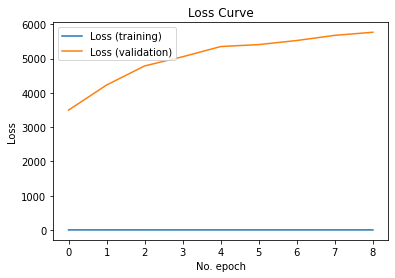

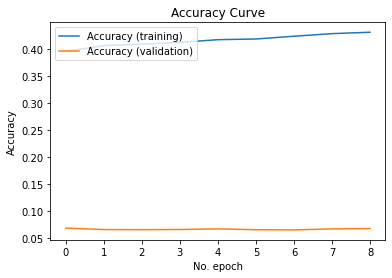

In [114]:
def plot_loss_curves(history):
  plt.plot(history.history['loss'][1:] , label='Loss (training)')
  plt.plot(history.history['val_loss'][1:], label='Loss (validation)')
  plt.title('Loss Curve')
  plt.ylabel('Loss')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

  plt.plot(history.history['sparse_categorical_accuracy'][1:] , label='Accuracy (training)')
  plt.plot(history.history['val_sparse_categorical_accuracy'][1:], label='Accuracy (validation)')
  plt.title('Accuracy Curve')
  plt.ylabel('Accuracy')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

plot_loss_curves(history)

Printing the model summary to summarize the layers of the model.

In [112]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8640128   
_________________________________________________________________
dense_5 (Dense)              (None, 48)                6192      
Total params: 8,646,320
Trainable params: 8,646,320
Non-trainable params: 0
_________________________________________________________________
None


Visual display of the layers of the model.

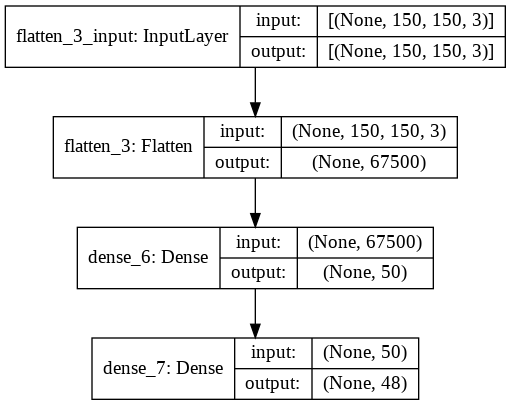

In [118]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### 2 - Convolutional neural network (CNN)

Results from the previous model were unsurpisingly poor. The model was very simplistic and wasn't optimal for images. CNNs on the other hand are well suited for data structured like images.

In [123]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),                               
  tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(48)  
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)

Epoch 1/20
64/64 [==============================] - 6s 82ms/step - loss: 2.2032 - sparse_categorical_accuracy: 0.3696 - val_loss: 306.7333 - val_sparse_categorical_accuracy: 0.0721
Epoch 2/20
64/64 [==============================] - 5s 78ms/step - loss: 1.6622 - sparse_categorical_accuracy: 0.4120 - val_loss: 516.7229 - val_sparse_categorical_accuracy: 0.0721
Epoch 3/20
64/64 [==============================] - 5s 78ms/step - loss: 1.6746 - sparse_categorical_accuracy: 0.4082 - val_loss: 784.9517 - val_sparse_categorical_accuracy: 0.0721
Epoch 4/20
64/64 [==============================] - 5s 77ms/step - loss: 1.6618 - sparse_categorical_accuracy: 0.4079 - val_loss: 1090.0260 - val_sparse_categorical_accuracy: 0.0723
Epoch 5/20
64/64 [==============================] - 5s 78ms/step - loss: 1.6505 - sparse_categorical_accuracy: 0.4085 - val_loss: 1364.5974 - val_sparse_categorical_accuracy: 0.0716
Epoch 6/20
64/64 [==============================] - 5s 79ms/step - loss: 1.6402 - sparse_cate

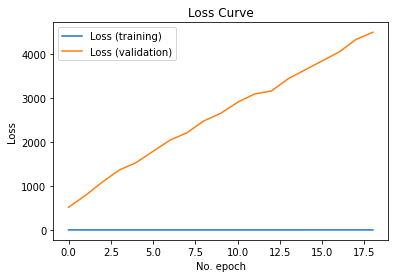

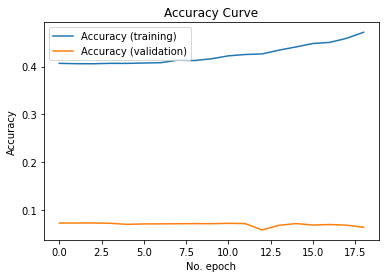

In [124]:
plot_loss_curves(history)

In [126]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),                               
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                               
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                               
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(48)  
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
    verbose=0
)

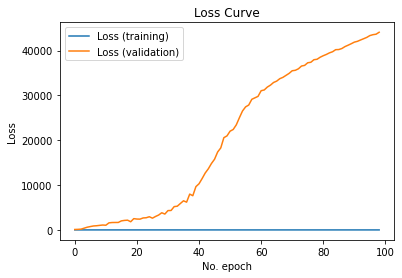

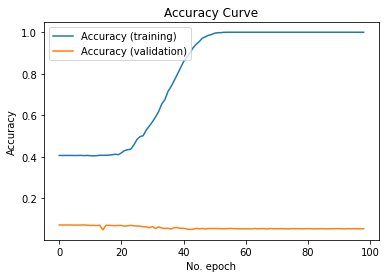

In [127]:
plot_loss_curves(history)

### 6 - ResNet

So, it seems pretty hard to think up an architecture that outperforms the baseline. Though it seems all hope is lost - is it not! The last trick of the day is to use a well known and well performing existing architecture (ResNet50) as a starting-off point.

(*Source*: https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/)


In [141]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input

resnet = ResNet50(weights="imagenet", input_tensor=Input(shape=(150, 150, 3)), include_top=False)
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Need to align the pool_size with the dimension of the last layer in the summary above.

In [142]:
model = resnet.output
model = tf.keras.layers.AveragePooling2D(pool_size=(5, 5))(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(256, activation="relu")(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(48)(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs=model)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    batch_size=128,
    epochs=18, 
    validation_data=ds_test,
    shuffle=True,
)

Epoch 1/18
64/64 [==============================] - 104s 1s/step - loss: 3.6318 - sparse_categorical_accuracy: 0.1068 - val_loss: 5.9153 - val_sparse_categorical_accuracy: 0.0721
Epoch 2/18
64/64 [==============================] - 51s 806ms/step - loss: 2.8966 - sparse_categorical_accuracy: 0.2459 - val_loss: 3.5757 - val_sparse_categorical_accuracy: 0.1112
Epoch 3/18
64/64 [==============================] - 52s 821ms/step - loss: 2.4122 - sparse_categorical_accuracy: 0.3583 - val_loss: 3.5702 - val_sparse_categorical_accuracy: 0.1112
Epoch 4/18
64/64 [==============================] - 53s 829ms/step - loss: 1.9585 - sparse_categorical_accuracy: 0.4805 - val_loss: 3.6776 - val_sparse_categorical_accuracy: 0.1112
Epoch 5/18
64/64 [==============================] - 53s 837ms/step - loss: 1.6156 - sparse_categorical_accuracy: 0.5622 - val_loss: 3.6852 - val_sparse_categorical_accuracy: 0.1086
Epoch 6/18
64/64 [==============================] - 54s 842ms/step - loss: 1.3004 - sparse_catego

Learning curves.

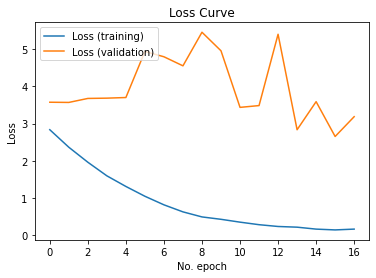

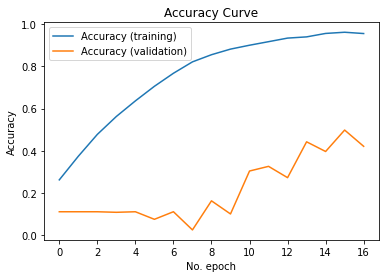

In [143]:
plot_loss_curves(history)

**Hint**: It is possible to continue training the same model. Notice the learning rate has decreased.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    batch_size=128,
    epochs=15, 
    validation_data=ds_test,
    shuffle=True,
)

In [117]:
for img, lbl in ds_test.take(1):
  pr = model.predict(img, batch_size=1)
  pr_c = model.predict_classes(img, batch_size=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(128, 48)